# CMA/ES PER SUBJECT
## Sigma Base, 1st try: new cov, lapse + sigma_base, sum LL


Similar to [notebook_fitexperimentallt_sigmabase_cmaes_3try_090816.ipynb](../fitexperiment_sigmabaseline_cmaes_08_2016/notebook_fitexperimentallt_sigmabase_cmaes_3try_090816.ipynb)

But now with independent CMA/ES fits per subject, uses a subset of the data.

Should then reload all of them together and check if the mean of the parameter corresponds to the other CMA/ES fits we did.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import progress

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import glob
import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

oldstdout = None

## Reload data

In [3]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/

metric = 'dist_nll'
folder_pattern = "cmaes_subjects_bays09_ll_1try_Mratiosigmaxsigmabaselinelapserate_subject*rep5_160816"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('experiment_subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)
        
subject_space = np.sort(df_all_fits['experiment_subject'].unique())

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016
Reloading data of Subject 1
Reloading data of Subject 8
Reloading data of Subject 4
Reloading data of Subject 3
Reloading data of Subject 7
Reloading data of Subject 11
Reloading data of Subject 2
Reloading data of Subject 10
Reloading data of Subject 5
Reloading data of Subject 12
Reloading data of Subject 6
Reloading data of Subject 9


In [4]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [5]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

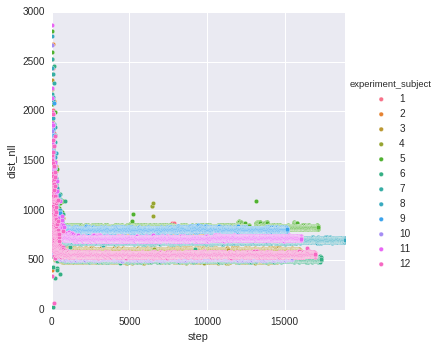

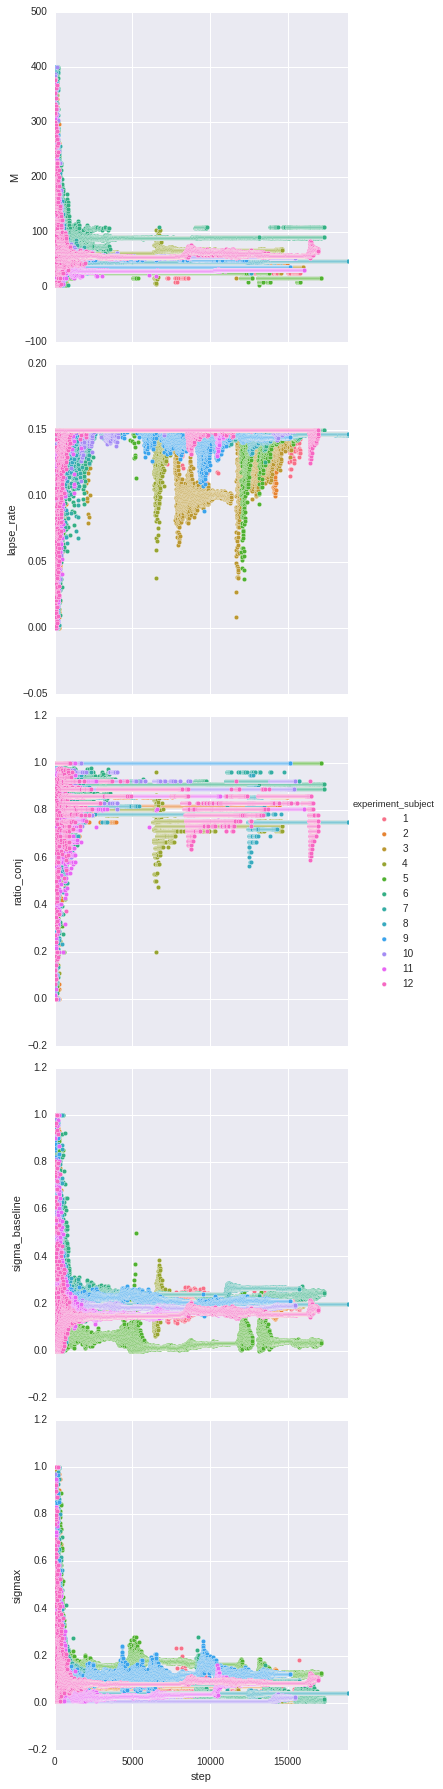

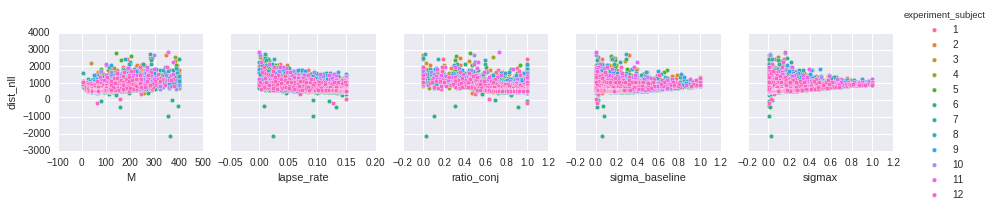

In [6]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric],
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5,
                )

g.set(ylim=(-1, 3000),
      xlim=(-1, df_best_fits['step'].max())
     )

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='experiment_subject',
            )


## Check parameters values obtained

In [6]:
df_bestparams_subjects = df_best_fits.groupby('experiment_subject').apply(
    lambda subDf: subDf.sort_values('step', ascending=False).head(120).median()
)
df_bestparams_subjects

,step,experiment_subject,dist_nll,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
experiment_subject,,,,,,,,
1,15778.5,1.0,701.304447,36.0,0.150000,1.000000,0.201067,0.005000
2,14879.5,2.0,738.277167,42.0,0.148007,0.857143,0.187498,0.090667
3,15929.5,3.0,593.524478,36.0,0.150000,1.000000,0.192290,0.010465
4,14549.5,4.0,503.068476,67.0,0.150000,0.731343,0.194534,0.005521
5,17069.5,5.0,830.582803,16.0,0.150000,1.000000,0.036228,0.124358
6,17279.5,6.0,511.066797,91.0,0.150000,0.890110,0.246068,0.012825
7,15689.5,7.0,693.717214,53.0,0.149870,0.924528,0.264210,0.093960
8,18839.5,8.0,703.771414,48.0,0.146738,0.750000,0.198894,0.040916
9,15089.5,9.0,807.326352,36.0,0.144466,1.000000,0.210709,0.121641


## Get plots for all subjects, and associated EM fits

In [7]:
if oldstdout is None:
    oldstdout = sys.stdout
    cmdlinestdout = open('/dev/stdout', 'w')

experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_subject_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

all_results = dict()
all_plots_fit_exp = dict()

for subject in progress.ProgressDisplay(subject_space):
    print FitExperimentAllTSubject for subject %d' % subject

    experiment_parameters.update(df_bestparams_subjects.loc[subject])
    for key in ['M', 'experiment_subject']:
        experiment_parameters[key] = int(experiment_parameters[key])
    
    with io.capture_output() as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
        fit_exp = experiment_launcher.all_vars['fit_exp']
        all_results[subject] = experiment_launcher.all_vars['all_outputs_data']
        all_plots_fit_exp[subject] = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

[0%] --
FitExperimentAllTSubject for subject 1
[8%] 8m24s
FitExperimentAllTSubject for subject 2
[16%] 7m39s
FitExperimentAllTSubject for subject 3
[25%] 6m52s
FitExperimentAllTSubject for subject 4
[33%] 6m11s
FitExperimentAllTSubject for subject 5
[41%] 5m33s
FitExperimentAllTSubject for subject 6
[50%] 4m50s
FitExperimentAllTSubject for subject 7
[58%] 4m9s
FitExperimentAllTSubject for subject 8
[66%] 3m22s
FitExperimentAllTSubject for subject 9
[75%] 2m31s
FitExperimentAllTSubject for subject 10
[83%] 1m38s
FitExperimentAllTSubject for subject 11
[91%] 48s
FitExperimentAllTSubject for subject 12
[100%] 9m36s


Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12


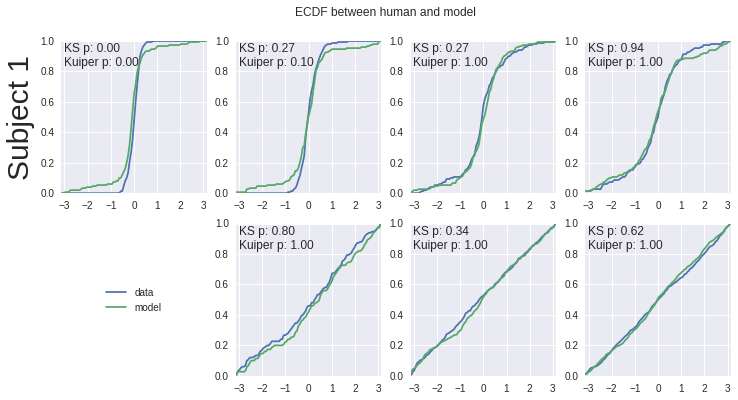

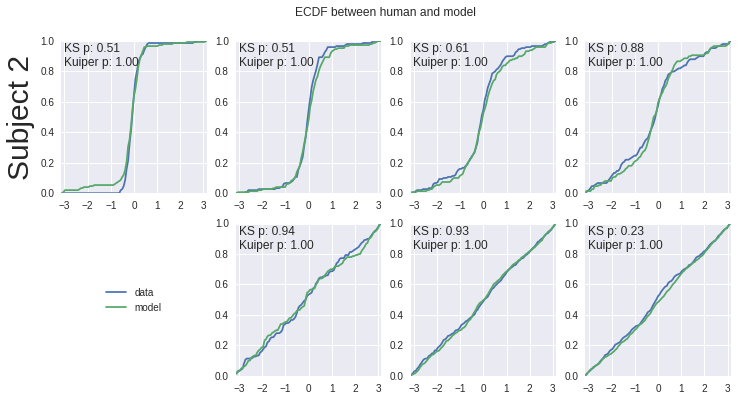

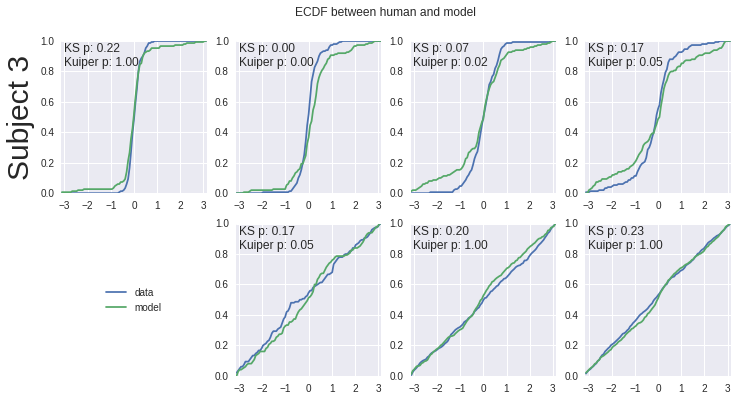

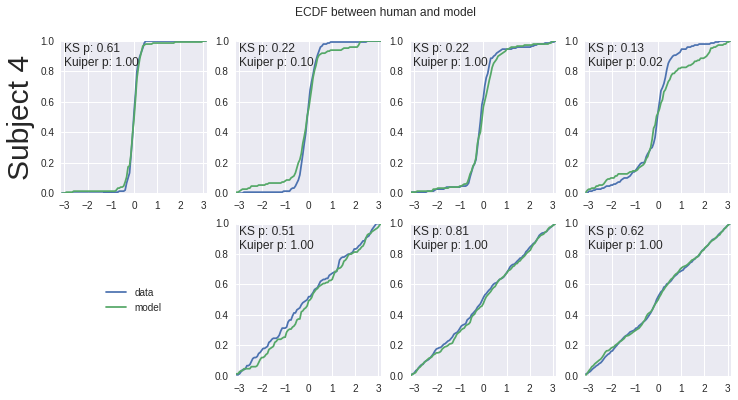

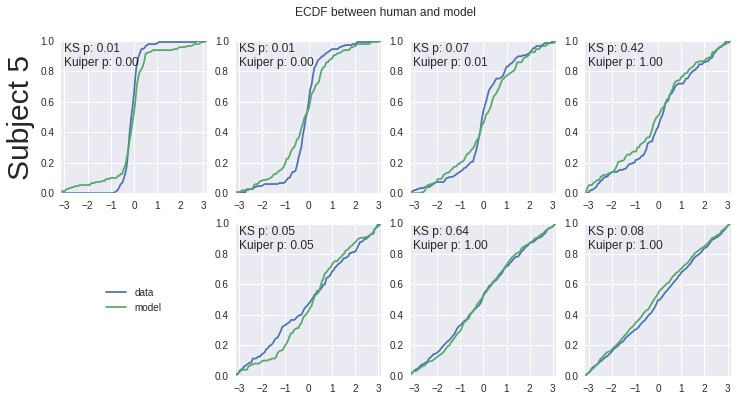

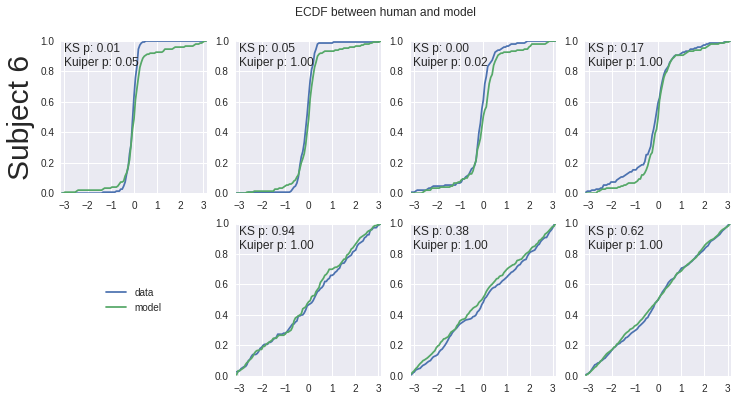

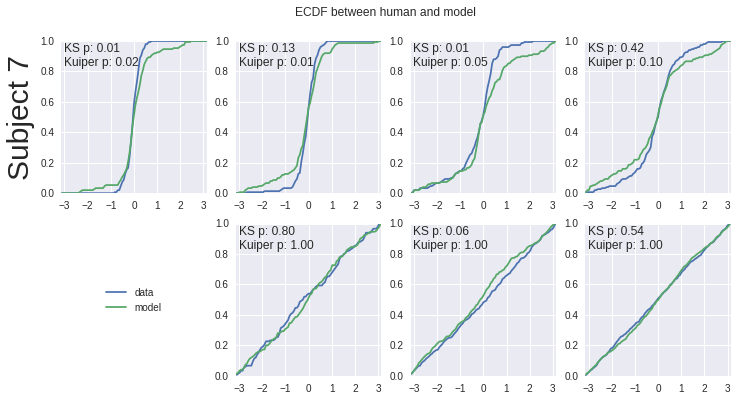

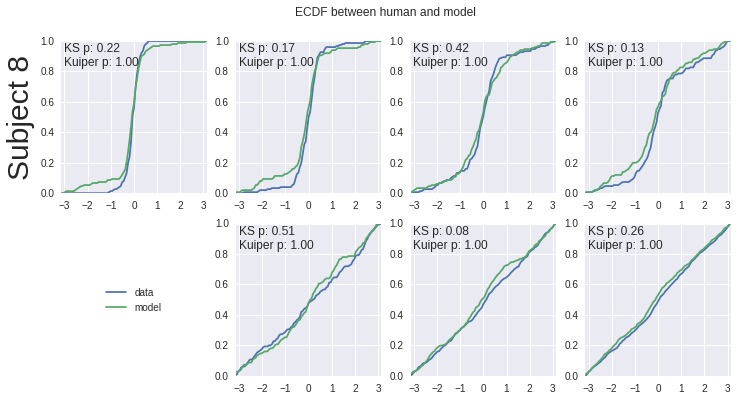

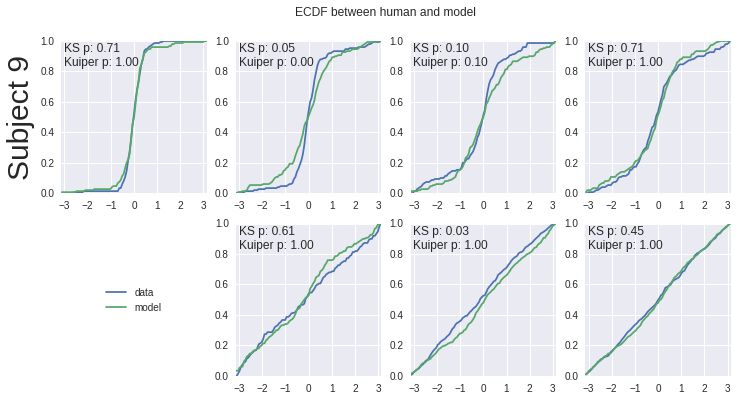

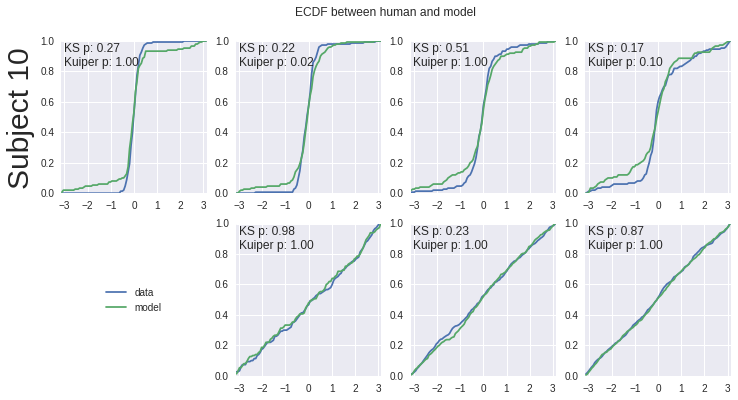

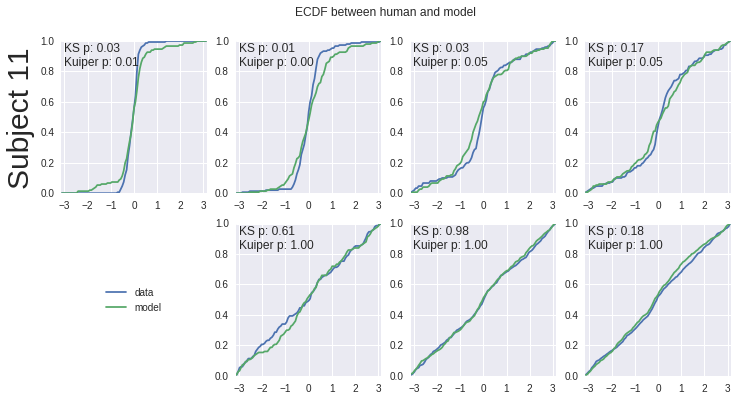

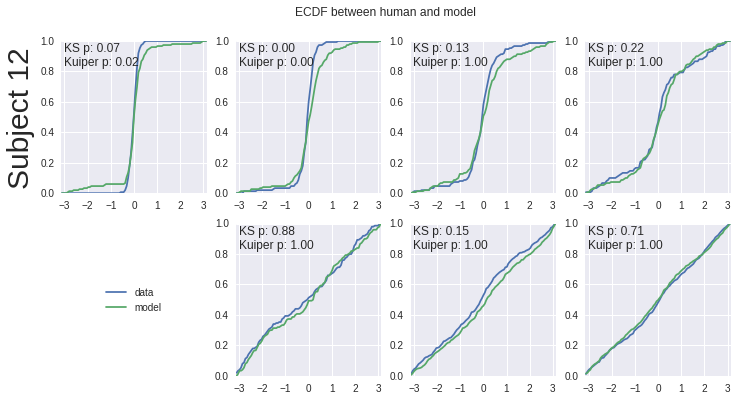

In [11]:
all_histogram_results = dict()

for subject in subject_space:
    print "Subject %d" % subject
    with io.capture_output(display=False, stderr=False) as captured:
        axes, all_histogram_results[subject] = all_plots_fit_exp[subject].plots_KS_comparison_fig2fig5(bins=100)
        axes[0, 0].set_ylabel('Subject %d' % subject, fontsize=30)


In [70]:
T_space = np.sort(all_histogram_results[subject]['kuiper_pval'].keys())

str_out = ""
for subject in subject_space:
    count_significant = 0
    str_out = str_out + "S:%3d | " % subject
    for condition in ['targets', 'nontargets']:
        for T, data in all_histogram_results[subject]['kuiper_pval'].iteritems():
            if condition in data:
                str_out = str_out + "%.3f " % data[condition]
                if data[condition] > 0.05:
                    count_significant += 1
        
        str_out = str_out + " | "
    
    str_out = str_out + " => %d good" % count_significant
    str_out = str_out + '\n'
print str_out

S:  1 | 0.001 0.100 1.000 1.000  | 1.000 1.000 1.000  |  => 6 good
S:  2 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  3 | 1.000 0.001 0.020 0.050  | 0.050 1.000 1.000  |  => 3 good
S:  4 | 1.000 0.100 1.000 0.020  | 1.000 1.000 1.000  |  => 6 good
S:  5 | 0.002 0.001 0.010 1.000  | 0.050 1.000 1.000  |  => 3 good
S:  6 | 0.050 1.000 0.020 1.000  | 1.000 1.000 1.000  |  => 5 good
S:  7 | 0.020 0.010 0.050 0.100  | 1.000 1.000 1.000  |  => 4 good
S:  8 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  9 | 1.000 0.001 0.100 1.000  | 1.000 1.000 1.000  |  => 6 good
S: 10 | 1.000 0.020 1.000 0.100  | 1.000 1.000 1.000  |  => 6 good
S: 11 | 0.005 0.001 0.050 0.050  | 1.000 1.000 1.000  |  => 3 good
S: 12 | 0.020 0.001 1.000 1.000  | 1.000 1.000 1.000  |  => 5 good



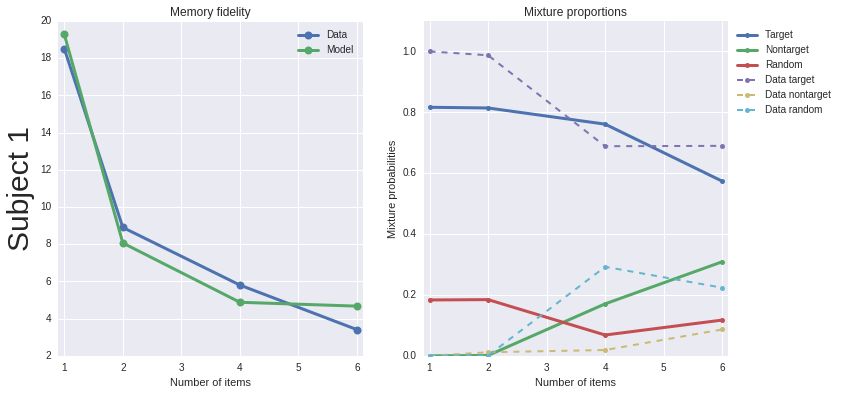

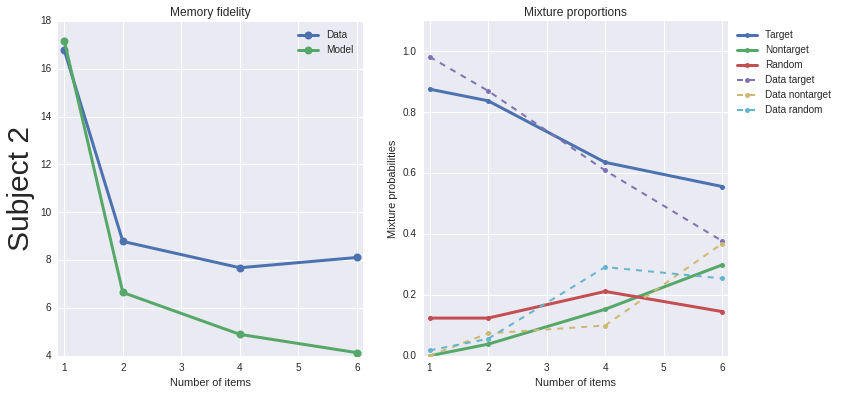

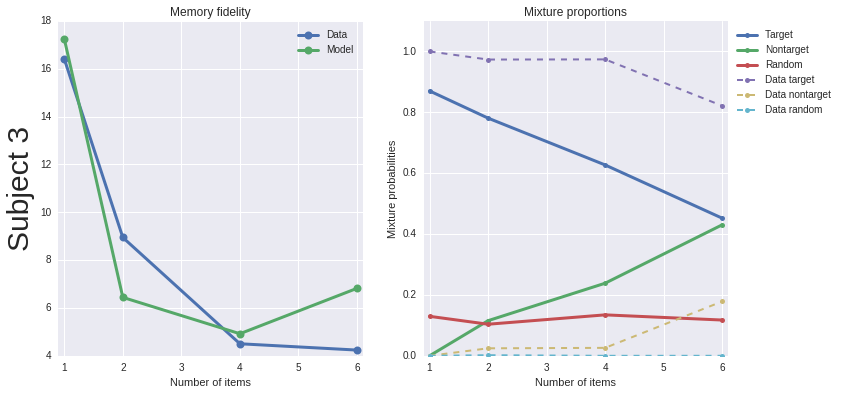

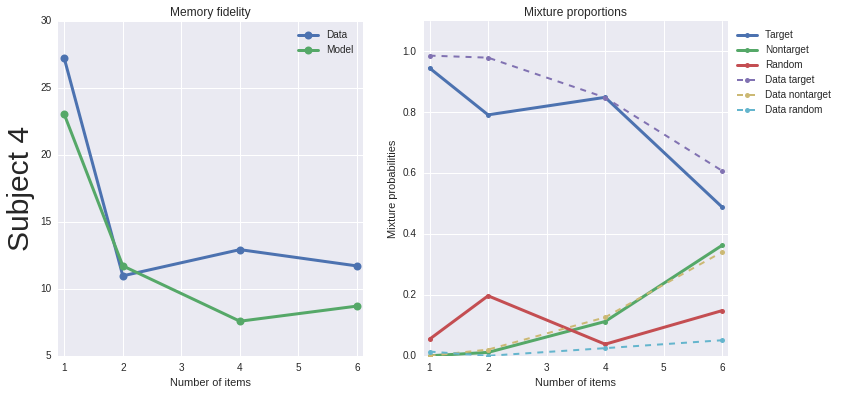

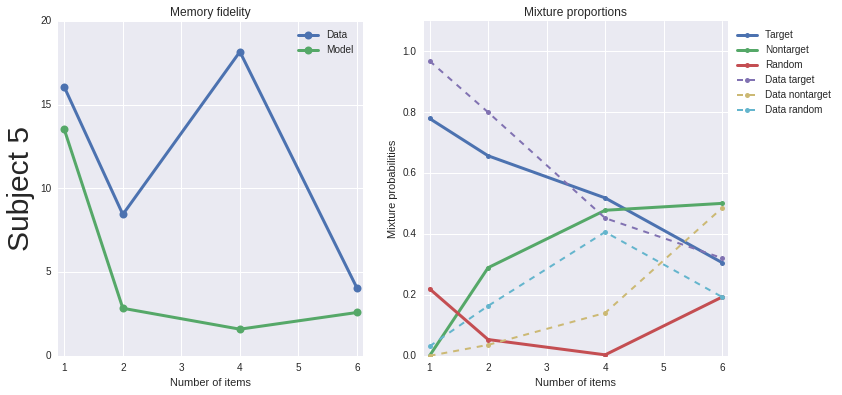

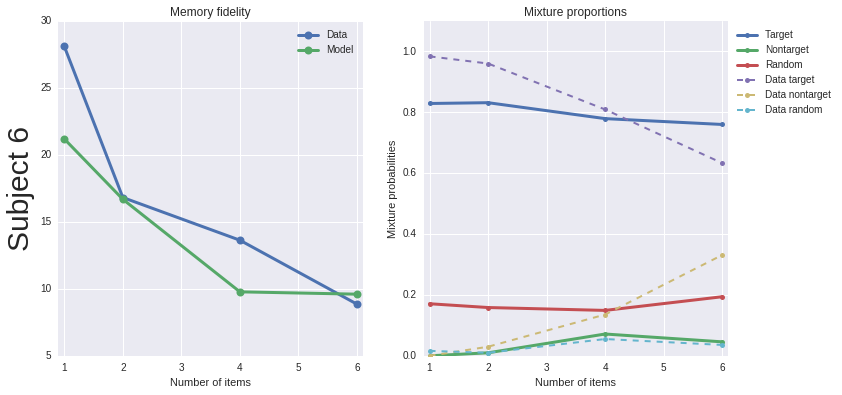

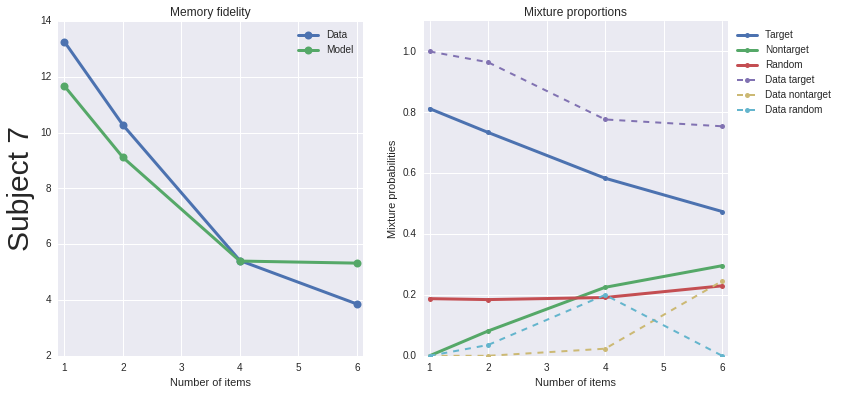

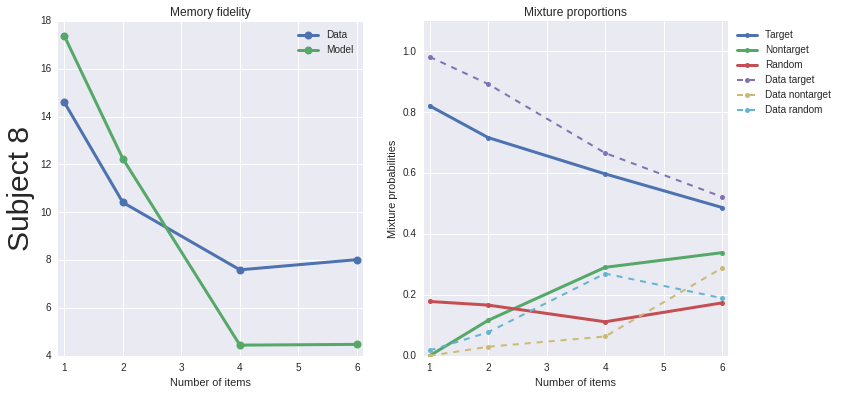

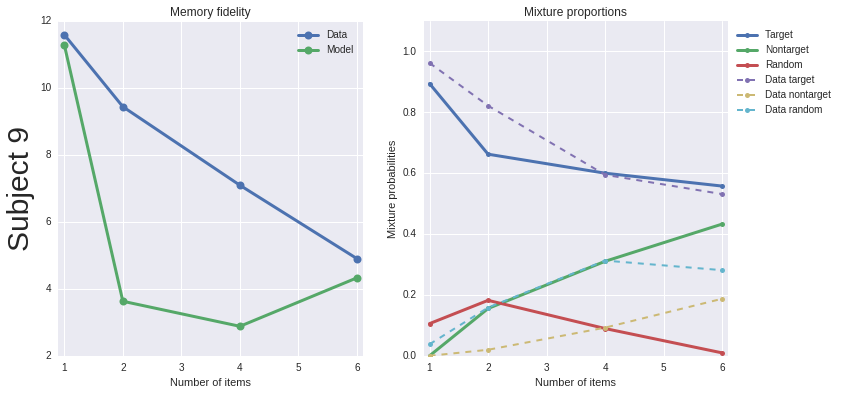

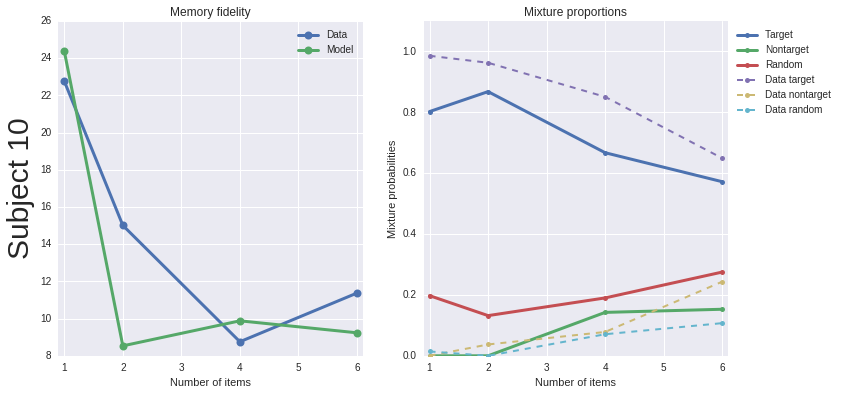

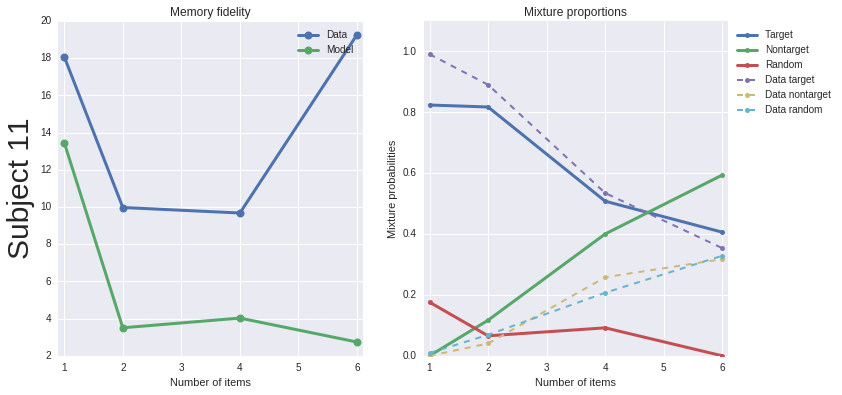

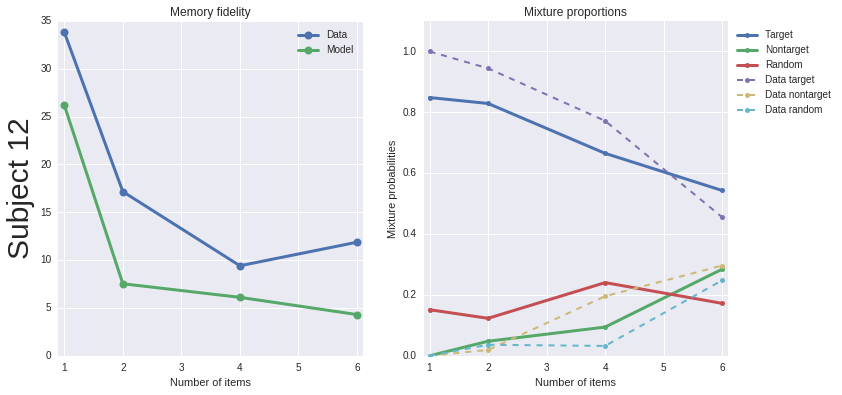

In [28]:
with io.capture_output(display=False) as captured:
    for subject in subject_space:
        axes = all_plots_fit_exp[subject].plots_memmixtcurves_fig6fig13(num_repetitions=1, 
                                                                        use_cache=True, 
                                                                        layout='horizontal')
        axes[0].set_ylabel('Subject %d' % subject, fontsize=30)

## Checking if average of parameters gives a good fit to the overall dataset

In [99]:
# Compute average parameter
df_avgparams_subjects = df_bestparams_subjects.mean()
df_avgparams_subjects

step                  16114.416667
experiment_subject        6.500000
dist_nll                657.710193
M                        48.000000
lapse_rate                0.148912
ratio_conj                0.884621
sigma_baseline            0.188205
sigmax                    0.059181
dtype: float64

In [101]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_avgparams_subjects)
for key in ['M', 'experiment_subject']:
    experiment_parameters[key] = int(experiment_parameters[key])
    
experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
avgparam_fit_exp = experiment_launcher.all_vars['fit_exp']
avgparam_results = experiment_launcher.all_vars['all_outputs_data']
avgparam_plots_fit_exp = PlotsFitExperimentAllTPaperTheo(avgparam_fit_exp)


Arguments: ['-f', '/run/user/5201/jupyter/kernel-f9b6897b-069c-42c3-81fc-34d80ab3d484.json']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'code_type': 'mixed', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'dist_nll': 657.71019315061392, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normalise_weights': 1, 'use_theoretical_cov

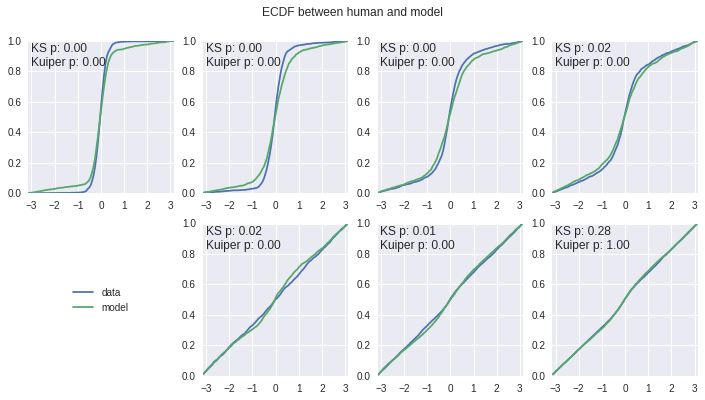

In [107]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

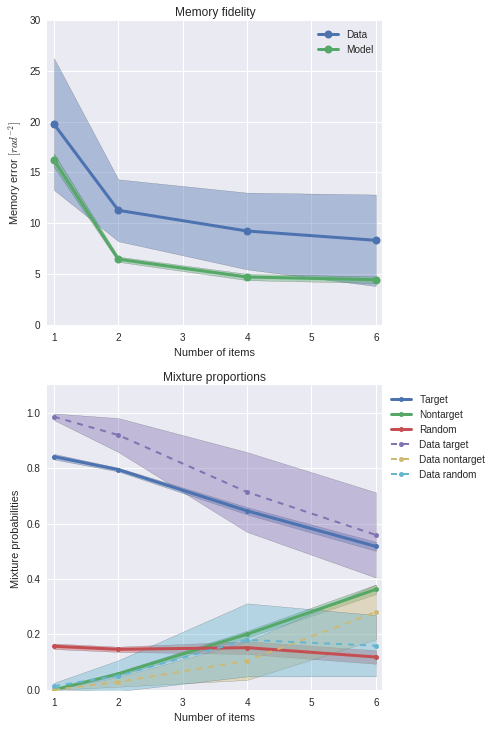

In [108]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

## Checking averaging the Subjects EM Fits

In [104]:
subjects_em_fits_list = []
for subject in subject_space:
    for T_i, T in enumerate(T_space):
        em_fits_subject = all_results[subject]['result_em_fits'].squeeze()
        subjects_em_fits_list.append(
            dict(subject=subject,
                 T=T,
                 em_kappa=em_fits_subject[T_i, 0],
                 em_target=em_fits_subject[T_i, 1],
                 em_nontarget=em_fits_subject[T_i, 2],
                 em_random=em_fits_subject[T_i, 3],
                 em_ll=em_fits_subject[T_i, 4],
                 em_bic=em_fits_subject[T_i, 5],
                 model_bic=all_results[subject]['result_bic'].squeeze()[T_i],
                 model_ll=all_results[subject]['result_ll_sum'].squeeze()[T_i]
                )
            )

subjects_em_fits_df = pd.DataFrame(subjects_em_fits_list)
subjects_em_fits_df

,T,em_bic,em_kappa,em_ll,em_nontarget,em_random,em_target,model_bic,model_ll,subject
0,1,262.563325,12.647595,-123.765710,0.000000,0.202438,0.797562,191.742275,-85.849867,1
1,2,244.220714,7.689123,-112.089086,0.033249,0.067609,0.899142,293.727416,-136.842438,1
2,4,401.421081,4.921315,-185.678635,0.159861,0.106919,0.733219,506.291522,-243.124490,1
3,6,484.446577,4.366281,-222.180747,0.328344,0.138164,0.533492,556.868262,-268.412860,1
4,1,181.803294,18.869938,-83.385694,0.000000,0.156207,0.843793,173.028357,-76.492908,2
5,2,314.189474,6.501881,-147.073467,0.075413,0.105840,0.818747,343.629276,-161.793367,2
6,4,395.001578,4.919735,-182.468883,0.139876,0.124979,0.735146,490.089179,-235.023319,2
7,6,511.735068,5.985878,-235.824993,0.456933,0.189888,0.353179,517.250723,-248.604091,2
8,1,228.060513,17.398791,-106.514304,0.000000,0.202305,0.797695,170.654097,-75.305778,3
9,2,323.549867,5.700061,-151.753663,0.057464,0.112403,0.830133,264.809306,-122.383382,3


In [105]:
# This computes the average fits across subjects. Exactly same as Fig 6!
subjects_pivot = subjects_em_fits_df[['em_kappa', 'em_target', 'em_nontarget', 'em_random', 'T']].groupby('T')

subjectsavg_emfit = dict(
    mean=subjects_pivot.mean().as_matrix(),
    std=subjects_pivot.std().as_matrix()
)

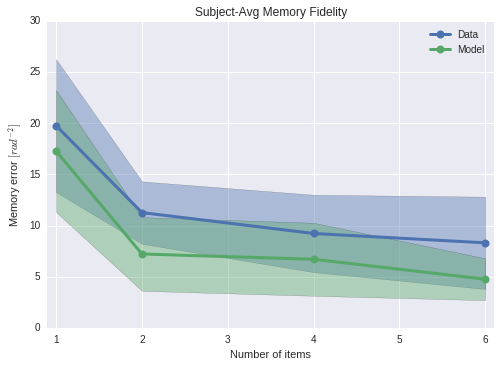

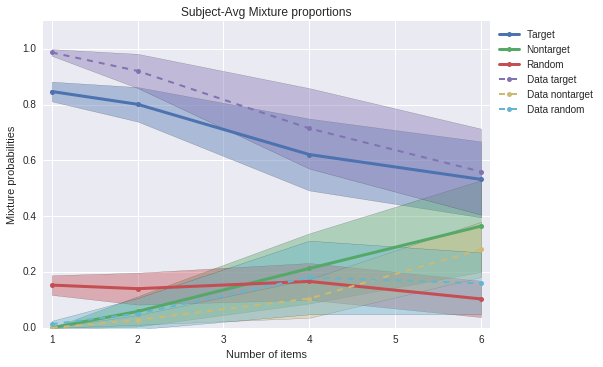

In [112]:
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_memcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Memory Fidelity")
avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_mixtcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Mixture proportions")